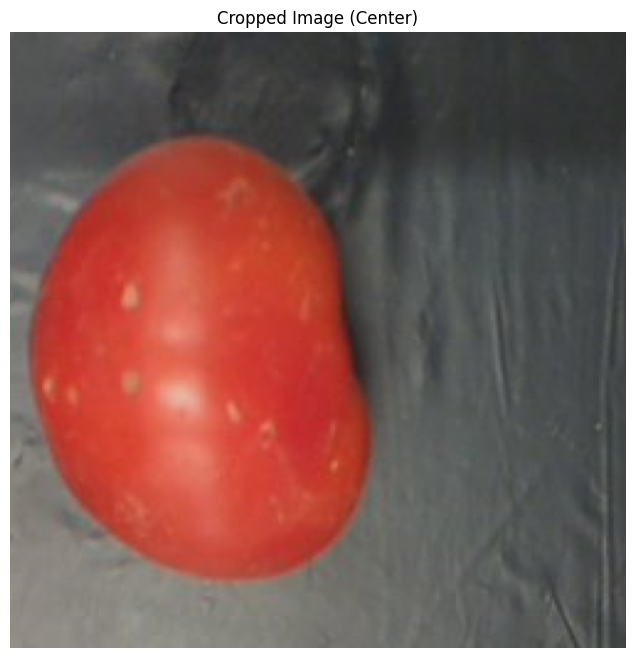

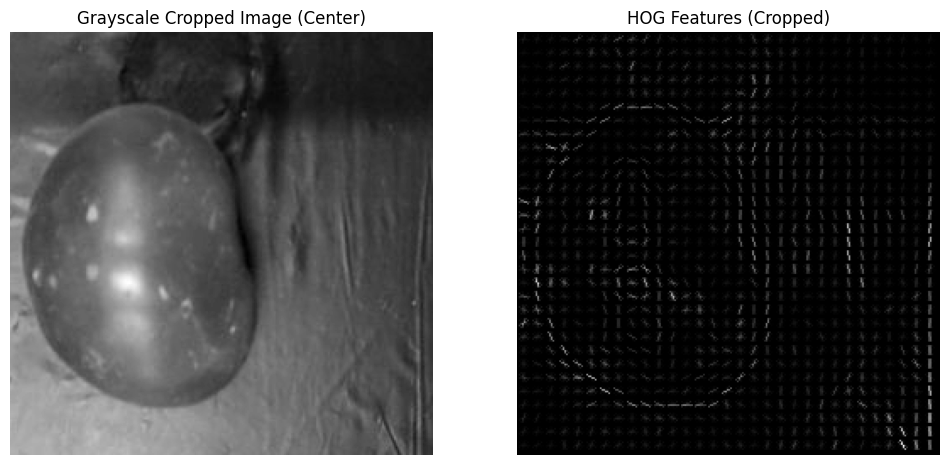

In [1]:
#testing hog
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, color, transform
from skimage.feature import hog
from skimage import io

# Load an example image
image_path = r"/kaggle/input/tomatofruits/Three Classes/Reject/reject (3).jpg"  # Replace with the path to your image
image = io.imread(image_path)

# Calculate the center coordinates of the image
center_y, center_x = np.array(image.shape[:2]) // 2

# Define the cropping box dimensions (adjust as needed)
crop_size = 250
crop_x_start = center_x - crop_size // 2
crop_x_end = center_x + crop_size // 2
crop_y_start = center_y - crop_size // 2
crop_y_end = center_y + crop_size // 2

# Crop the image to focus on the middle
cropped_image = image[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

# Plot the cropped image before applying HOG
plt.figure(figsize=(8, 8))
plt.imshow(cropped_image)
plt.title('Cropped Image (Center)')
plt.axis('off')
plt.show()

# Convert the cropped image to grayscale
gray_cropped_image = color.rgb2gray(cropped_image)

# Compute HOG features
hog_features, hog_image = hog(gray_cropped_image, block_norm='L2-Hys', visualize=True)

# Visualize the HOG features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_cropped_image, cmap=plt.cm.gray)
plt.title('Grayscale Cropped Image (Center)')
plt.axis('off')

plt.subplot(1, 2, 2)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('HOG Features (Cropped)')
plt.axis('off')

plt.show()


In [2]:
from skimage import io, transform, feature
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def preprocess(image_path):
    # Load the image
    image = io.imread(image_path)

    # Resize the image to 128x128 pixels
    resized_image = transform.resize(image, (128, 128), mode='reflect')

    # Check the number of channels and extract the first 3 if more than 3
    if resized_image.shape[2] > 3:
        resized_image = resized_image[:, :, :3]

    # Calculate the center coordinates of the resized image
    center_y, center_x = np.array(resized_image.shape[:2]) // 2

    # Define the cropping box dimensions (adjust as needed)
    crop_size = 100
    crop_x_start = center_x - crop_size // 2
    crop_x_end = center_x + crop_size // 2
    crop_y_start = center_y - crop_size // 2
    crop_y_end = center_y + crop_size // 2

    # Crop the resized image
    cropped_image = resized_image[crop_y_start:crop_y_end, crop_x_start:crop_x_end]
    cropped_image = color.rgb2gray(cropped_image)
    # Compute HOG features
    hog_features = feature.hog(
        cropped_image,
        block_norm='L2-Hys',
        pixels_per_cell=(8, 8)
    )

    return hog_features


In [29]:
images=[]
labels=[]
for i in range(1,801):
    image_path = f"/kaggle/input/tomatofruits/Three Classes/Reject/reject ({i}).jpg"
    images.append(preprocess(image_path))
    labels.append(0)
for i in range(1,801):
    image_path = f"/kaggle/input/tomatofruits/Three Classes/Unripe/unripe ({i}).jpg"
    images.append(preprocess(image_path))
    labels.append(1)

In [30]:
len(images)

1600

In [31]:
len(labels)

1600

In [32]:
X,Y=np.array(images), np.array(labels)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [34]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
model=LogisticRegression(max_iter=500)

In [35]:
model.fit(x_train,y_train)

LogisticRegression(max_iter=500)

In [36]:
from sklearn.metrics import accuracy_score

# Evaluate performance
test_accuracy = round(accuracy_score(y_test, model.predict(x_test))*100,2)

print(f'Test Accuracy: {test_accuracy}%')

Test Accuracy: 97.92%


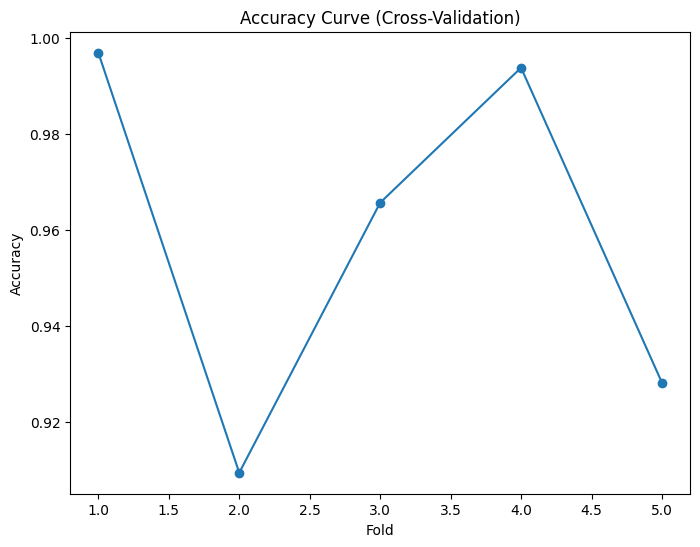

In [37]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')  # Change cv and scoring as needed

# Plotting the Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Accuracy Curve (Cross-Validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

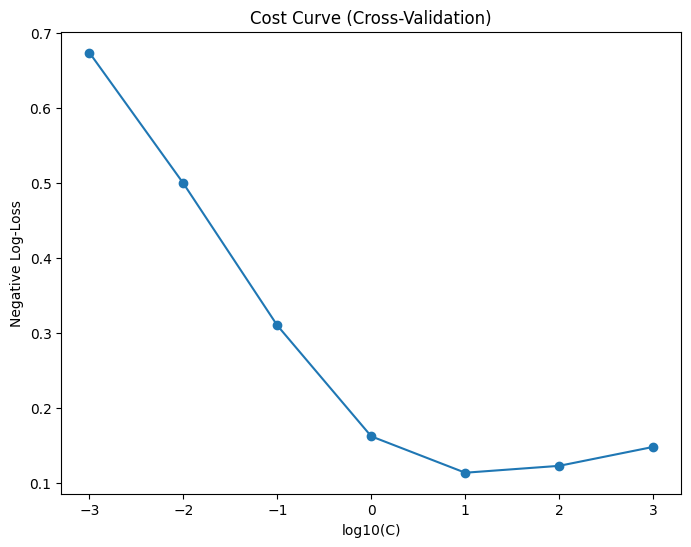

In [38]:
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and Y are your features and labels

C_values = np.logspace(-3, 3, 7)

# Create a Logistic Regression model with cross-validation
model = LogisticRegressionCV(Cs=C_values, cv=5, scoring='neg_log_loss', max_iter=1000)

# Fit the model
model.fit(X, Y)

# Plotting the Cost Curve
mean_scores = np.mean(list(model.scores_.values()), axis=1).flatten()  # Flatten the array
plt.figure(figsize=(8, 6))
plt.plot(np.log10(C_values), -mean_scores, marker='o')  # Negate scores for negative log-likelihood
plt.title('Cost Curve (Cross-Validation)')
plt.xlabel('log10(C)')
plt.ylabel('Negative Log-Loss')
plt.show()


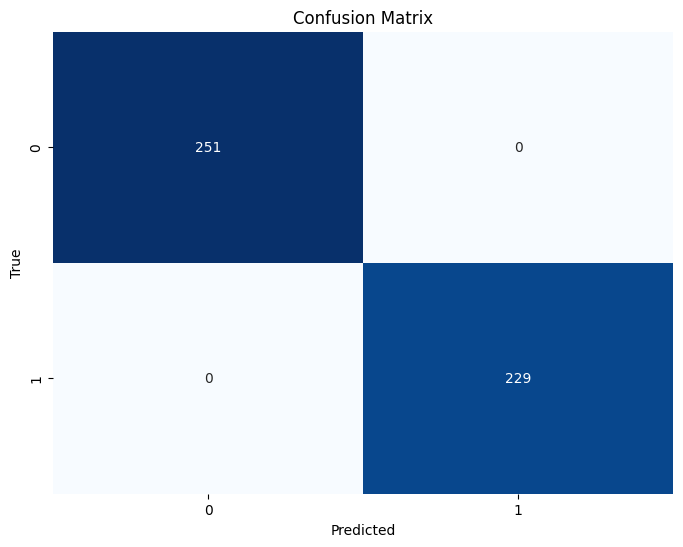

In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, auc,roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]



# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

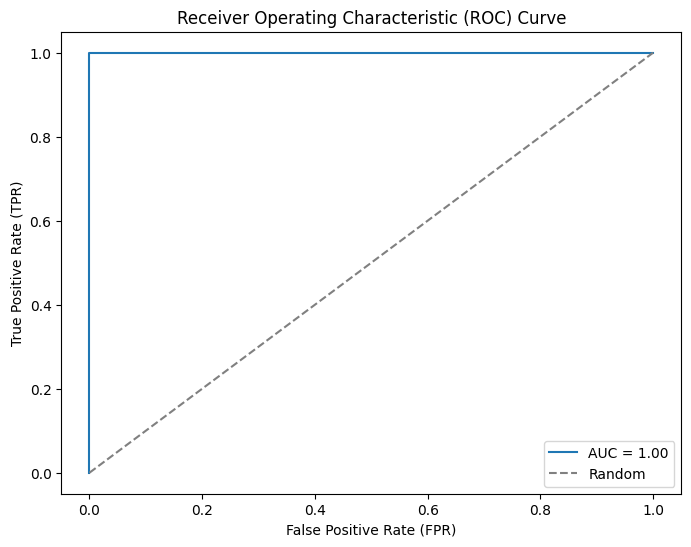

In [40]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       251
           1       1.00      1.00      1.00       229

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [42]:
from sklearn.cluster import KMeans

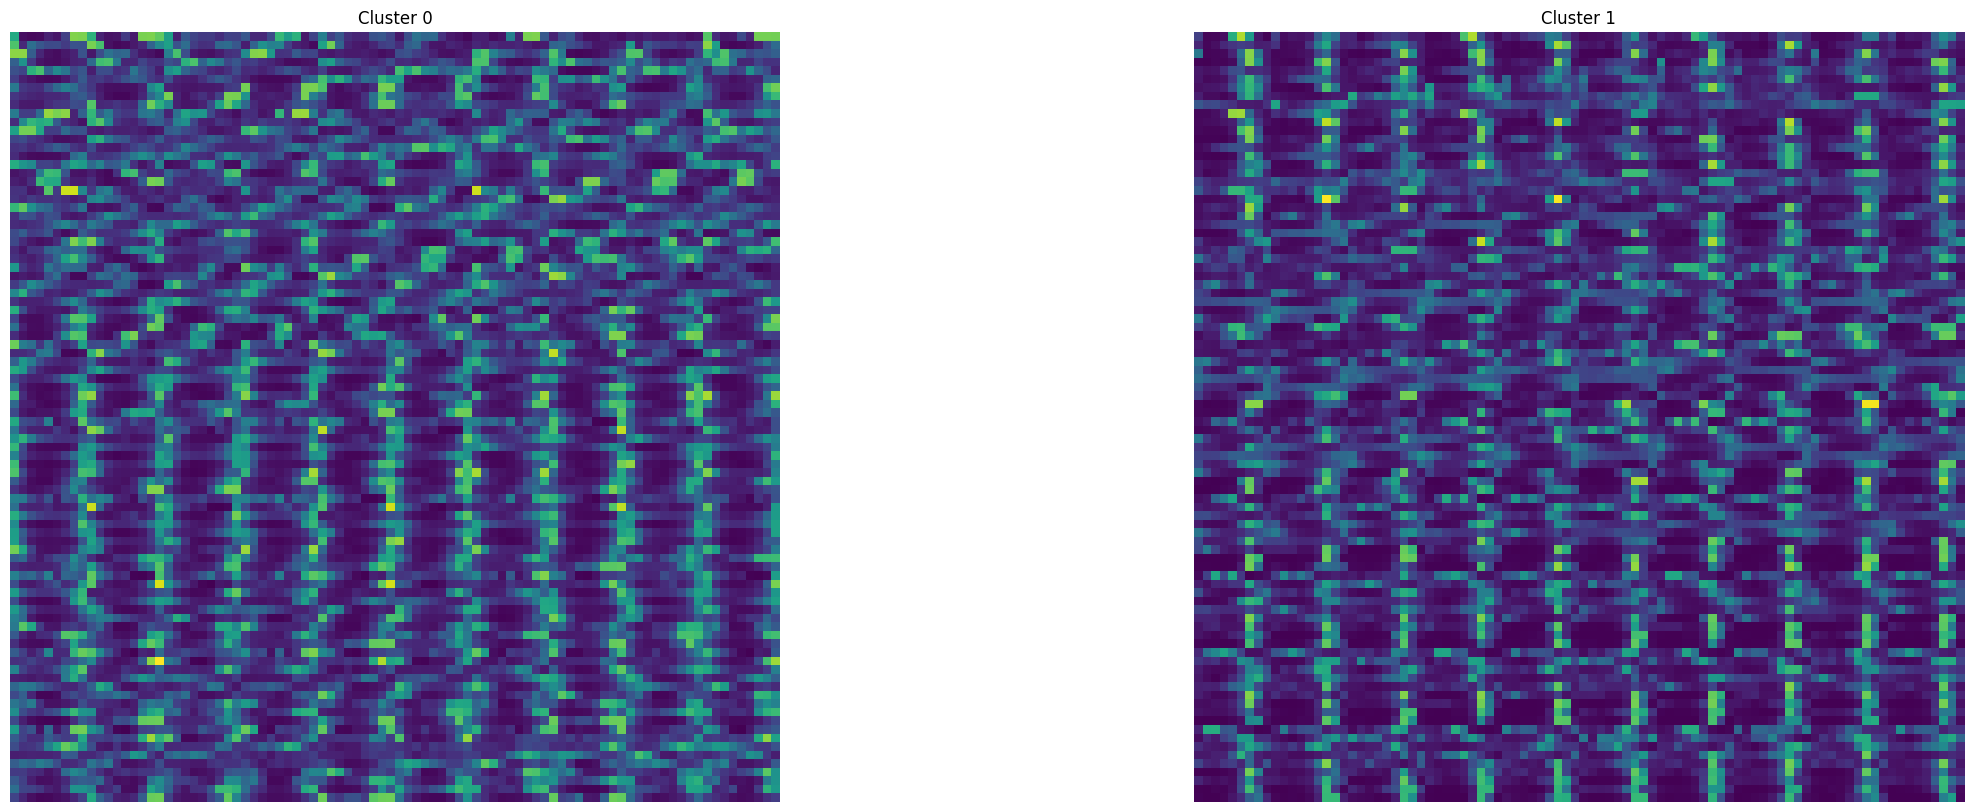

In [45]:
n_clusters = 2

# Apply k-means clustering
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(X)

# Visualize the cluster centers (representative images)
fig, ax = plt.subplots(1, n_clusters, figsize=(28, 10))

for i in range(n_clusters):
    center_image = kmeans.cluster_centers_[i].reshape(90, 90)  # Reshape to original dimensions
    ax[i].imshow(center_image)
    ax[i].axis('off')
    ax[i].set_title(f'Cluster {i}')

plt.show()

Silhouette Score: 0.47010423669942397


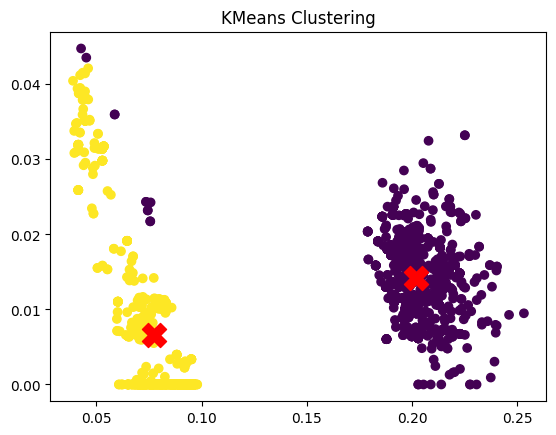

In [46]:
from sklearn.metrics import silhouette_score
# Silhouette analysis
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Visualize clusters
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title('KMeans Clustering')
plt.show()

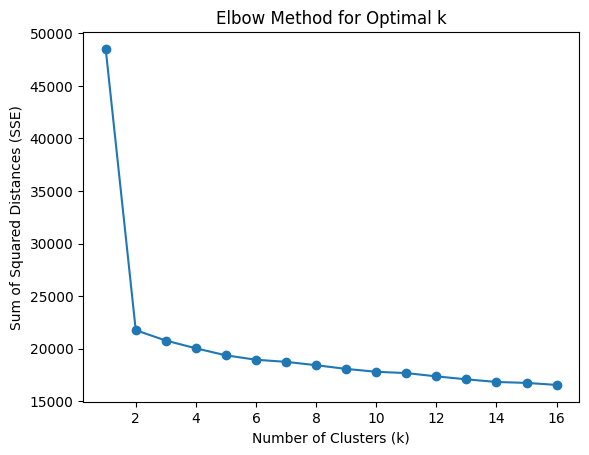

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_values = range(1, 17)

sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10,random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()
